In [1]:
def read_option_file(fileName):
    import pandas as pd
    import math

    csv = pd.read_csv(fileName,
                    names=['UnderlyingSymbol','UnderlyingPrice','Exchange',
                        'OptionSymbol','OptionExt','Type','Expiration',
                        'DataDate','Strike','Last','Bid','Ask','Volume',
                        'OpenInterest','IV','Delta','Gamma','Theta','Vega','AKA'])

    # Remove the exchange columns...
    csv = csv.drop(columns=['Exchange','OptionExt','AKA'])

    # Parse the date columns into datetimes...
    csv['Expiration'] = pd.to_datetime(csv['Expiration'])
    csv['DataDate'] = pd.to_datetime(csv['DataDate'])
    csv['TimeRemaining'] = (csv['Expiration'] - csv['DataDate']).dt.days

    # Tag the quality of the option
    bins = [0, 0.16, 0.32, 0.64, 1]
    moneynes = pd.cut(x=abs(csv.Delta), bins=bins, labels=['OTM','NTM','ATM','ITM'])
    csv['ITM'] = moneynes == 'ITM'
    csv['NTM'] = moneynes == 'NTM'
    csv['ATM'] = moneynes == 'ATM'
    csv['OTM'] = moneynes == 'OTM'


    # OneHotEncode the Type property
    csv['IsCall'] = csv['Type'] == 'call'
    csv['IsPut'] = csv['Type'] == 'put'
    csv = csv.drop(columns=['Type'])

    # Filter out no/bid records...
    csv = csv[(csv.Bid>0) & (csv.OpenInterest >0)]

    # Sort the values
    csv = csv.sort_values(by=['Expiration','DataDate','Strike'])
    return csv


In [17]:
!pip install keras
!pip install pydot

In [ ]:
spy = read_option_file('SPY.csv')
print(spy.shape)
print(spy.head())

In [10]:
def split_csv(csv, test_size):
    x_data = csv[['UnderlyingPrice','Strike','IV','Delta','Gamma','Theta','Vega',
              'TimeRemaining','IsCall','IsPut']]

    # Calculate the y_predict
    midprice = (csv['Bid']+csv['Ask'])/2
    notional = csv['UnderlyingPrice'] * csv['Delta']

    y_data = midprice #/ csv['UnderlyingPrice']

    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=42)

    #from sklearn.preprocessing import StandardScaler
    #scaler = StandardScaler().fit(x_train)
    #x_train = scaler.transform(x_train)
    #x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_csv(spy, test_size=0.3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5874250, 10)
(2517537, 10)
(5874250,)
(2517537,)


In [51]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise

model = Sequential([
    Dense(64, input_dim=10),
    Activation('relu'),
    GaussianNoise(0.5),
    Dense(1, kernel_initializer='normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [52]:
history = model.fit(x_train, y_train, epochs=5, batch_size=128)

Epoch 1/3
986552/986552 [==============================] - 13s 13us/step - loss: 3.5968 - accuracy: 0.0055
Epoch 2/3
986552/986552 [==============================] - 13s 14us/step - loss: 1.5799 - accuracy: 0.0071
Epoch 3/3
986552/986552 [==============================] - 13s 14us/step - loss: 0.9669 - accuracy: 0.0080


In [53]:
score = model.evaluate(x_test, y_test)
score

422809/422809 [==============================] - 8s 18us/step


[0.48870307689414877, 0.011054636910557747]

In [54]:
score

[0.48870307689414877, 0.011054636910557747]

loss
accuracy


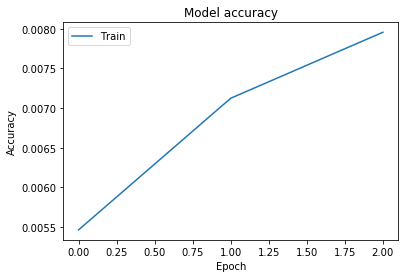

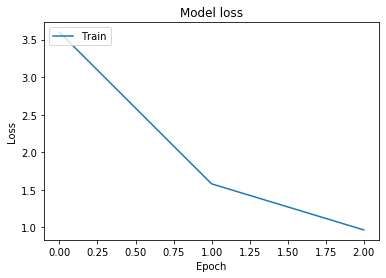

In [55]:
import matplotlib.pyplot as plt

for x in history.history:
    print(x)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [50]:
qqq = read_option_file('QQQ.csv')
qqq = qqq[qqq.ATM | qqq.NTM]
print(qqq.shape)

x_train, x_test, y_train, y_test = split_csv(qqq, test_size=0.3)
#model.evaluate(x_train, y_train)

(1409361, 23)


In [30]:
model.predict(x_train[0:20])

array([[-0.12475972],
       [ 0.68252045],
       [ 6.1398706 ],
       [ 1.4872643 ],
       [20.614325  ],
       [ 1.7420777 ],
       [ 8.418054  ],
       [ 0.17530537],
       [ 3.9424796 ],
       [ 3.2111478 ],
       [10.3315325 ],
       [ 3.3392894 ],
       [ 5.0916405 ],
       [ 4.6669383 ],
       [ 9.212279  ],
       [ 0.446115  ],
       [-0.3066684 ],
       [ 0.74131185],
       [-0.22830711],
       [ 3.8718243 ]], dtype=float32)

In [58]:
from keras.layers import LSTM

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, LSTM

model = Sequential([
    Dense(64, input_dim=10),
    Activation('relu'), 
    Dense(64),
    GaussianNoise(0.5),
    Dense(64),
    Dense(1, kernel_initializer='normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'acc'])

spy = read_option_file('SPY.csv')
spy = spy[spy.ATM | spy.NTM]
print(spy.shape)

x_train, x_test, y_train, y_test = split_csv(spy, test_size=0.5)
history = model.fit(x_train, y_train, epochs=10, batch_size=100)
score = model.evaluate(x_test, y_test)
score

(2496117, 23)
Epoch 1/10
1248058/1248058 [==============================] - 27s 22us/step - loss: 10.7858 - accuracy: 0.0021 - acc: 0.0021
Epoch 2/10
1248058/1248058 [==============================] - 27s 22us/step - loss: 3.0048 - accuracy: 0.0028 - acc: 0.0028
Epoch 3/10
1248058/1248058 [==============================] - 27s 22us/step - loss: 1.9166 - accuracy: 0.0034 - acc: 0.0034
Epoch 4/10
1248058/1248058 [==============================] - 27s 22us/step - loss: 1.2179 - accuracy: 0.0042 - acc: 0.0042
Epoch 5/10
1248058/1248058 [==============================] - 27s 22us/step - loss: 1.1329 - accuracy: 0.0045 - acc: 0.0045
Epoch 6/10
1248058/1248058 [==============================] - 27s 22us/step - loss: 1.6512 - accuracy: 0.0044 - acc: 0.0044
Epoch 7/10
1248058/1248058 [==============================] - 27s 21us/step - loss: 0.9912 - accuracy: 0.0047 - acc: 0.0047
Epoch 8/10
1248058/1248058 [==============================] - 27s 21us/step - loss: 0.8099 - accuracy: 0.0048 - acc: 

[0.5606617752010994, 0.005608709063380957, 0.005608709063380957]